In [163]:
# Import libraries
import os
import re
import io
import sys
import pandas as pd
import numpy as np
import pickle
import torch
import matplotlib.pyplot as plt
%matplotlib inline
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity

In [165]:
# Read data
minutes = pd.read_pickle('../data/data-gen/sent_minutes.p')
seps    = pd.read_pickle('../data/data-gen/sent_seps.p')
beigeb  = pd.read_pickle('../data/data-gen/sent_beigebook.p')

In [166]:
print(minutes.shape)
minutes.head()

(4389, 3)


,doc_id,sentence_id,text
0,20071031,1,conjunction fomc meeting october meeting parti...
1,20071031,2,projec tions summary economic projections atta...
2,20071031,3,discussion economic outlook situa tion project...
3,20071031,4,conditions financial markets improved septembe...
4,20071031,5,easing monetary policy participants expected e...


In [167]:
print(seps.shape)
seps.head()

(4520, 3)


,doc_id,sentence_id,text
0,20071031,1,summary economic projections conjunction octob...
1,20071031,2,projections based information con clusion octo...
2,20071031,3,monetary policy defined future policy foster o...
3,20071031,4,projections summarized table chart suggest fom...
4,20071031,5,ahead output projected expand pace close run t...


In [168]:
print(beigeb.shape)
beigeb.head()

(6345, 3)


,doc_id,sentence_id,text
0,20071031,1,beige book national summary october anecdotal ...
1,20071031,2,growth similar observed beige book districts a...
2,20071031,3,louis
3,20071031,4,economy grew slower rate districts cleveland d...
4,20071031,5,expansion variously characterized moderate mod...


In [5]:
model = SentenceTransformer('c:/Users/d1rxh02/Downloads/rfolder/SentenceTransformers/roberta-large-nli-stsb-means-tokens', device = 'cuda' )

In [171]:
# example
sentences1 = minutes[minutes.doc_id=='20080130'].text
sentences2 = seps[seps.doc_id=='20080130'].text
print(sentences1.shape)
print(sentences2.shape)

(67,)
(56,)


In [172]:
# Have to reset the index or an error pops up
sentences1 = sentences1.reset_index()
sentences2 = sentences2.reset_index()

In [174]:
# Compute embeddings for both lists
# The result is a list of vectors, one for each sentence
embeddings1 = model.encode(sentences1.text, convert_to_tensor=True)
embeddings2 = model.encode(sentences2.text, convert_to_tensor=True)

In [175]:
type(embeddings1)

torch.Tensor

In [176]:
embeddings1.shape
embeddings2.shape

torch.Size([56, 1024])

In [177]:
# Compute cosine-similarities
# This calculates the similarities between all pairs of vectors
cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)

In [178]:
cosine_scores.shape

torch.Size([67, 56])

In [180]:
# This is 2-dim array of cross-pairs
cosine_scores

tensor([[0.9024, 0.7340, 0.5987,  ..., 0.4959, 0.3602, 0.5570],
        [0.3936, 0.4746, 0.4435,  ..., 0.4256, 0.3156, 0.4018],
        [0.5028, 0.5167, 0.2500,  ..., 0.3385, 0.3395, 0.2817],
        ...,
        [0.5282, 0.4829, 0.5473,  ..., 0.5658, 0.5898, 0.5626],
        [0.2224, 0.3900, 0.4823,  ..., 0.4953, 0.3920, 0.3966],
        [0.4481, 0.4789, 0.4873,  ..., 0.5254, 0.4351, 0.4270]],
       device='cuda:0')

In [181]:
# Calculate average of embeddings
# This provides one vector per document
# Alternatively, calculate sum
embedding_1 = torch.mean(embeddings1, dim = 0)
embedding_2 = torch.mean(embeddings2, dim = 0)

In [182]:
# Calculate cosine similarity
# This returns a scalar measure
cos_sim = torch.nn.CosineSimilarity(dim = 0)
result = cos_sim(embedding_1, embedding_2)
print(result)

tensor(0.8456, device='cuda:0')


In [184]:
def calc_simil_docs(doc1, doc2):
    # Calculates cosine similarity of a pair of documents
    # Each document is a series of sentences
    
    # Calculate embeddings by averaging the individual sentence embeddings
#     embeddings1 = []
#     for i in range(0, doc1.count()):
#         emb = model.encode(doc1.iloc[i], convert_to_tensor=True)
#         embeddings1.append(emb)
#     embeddings2 = []
#     for i in range(0, doc2.count()):
#         emb = model.encode(doc2.iloc[i], convert_to_tensor=True)
#         embeddings2.append(emb)
        
    # Calculate embeddings of all sentences at once
    embeddings1 = model.encode(doc1.reset_index(drop = True), convert_to_tensor=True)
    embeddings2 = model.encode(doc2.reset_index(drop = True), convert_to_tensor=True)
        
    
    # Average embeddings of each document to have 
    # a single tensor per document
#     embedding_1 = torch.mean(torch.stack(embeddings1), dim = 0)
#     embedding_2 = torch.mean(torch.stack(embeddings2), dim = 0)
    embedding_1 = torch.mean(embeddings1, dim = 0)
    embedding_2 = torch.mean(embeddings2, dim = 0)

    
    # Calculate cosine similarity between the two tensors
    cos_sim = torch.nn.CosineSimilarity(dim = 0)
    result = cos_sim(embedding_1, embedding_2)
    return result

In [185]:
# Calculate similarites between all the pairs of documents
simil_minutes_sep = []
simil_minutes_bb  = []
simil_seps_bb     = []
for docid in minutes.doc_id.unique():
    print('Now processing doc_id=', docid,' ...')
    sentences1 = minutes[minutes.doc_id == docid].text
    sentences2 = seps[seps.doc_id == docid].text
    sentences3 = beigeb[beigeb.doc_id == docid].text
    cs_ms = calc_simil_docs(sentences1, sentences2)
    cs_mb = calc_simil_docs(sentences1, sentences3)
    cs_sb = calc_simil_docs(sentences2, sentences3)
    simil_minutes_sep.append(cs_ms)
    simil_minutes_bb.append(cs_mb)
    simil_seps_bb.append(cs_sb)

Now processing doc_id= 20071031  ...
Now processing doc_id= 20080130  ...
Now processing doc_id= 20080430  ...
Now processing doc_id= 20080625  ...
Now processing doc_id= 20081029  ...
Now processing doc_id= 20090128  ...
Now processing doc_id= 20090429  ...
Now processing doc_id= 20090624  ...
Now processing doc_id= 20091104  ...
Now processing doc_id= 20100127  ...
Now processing doc_id= 20100428  ...
Now processing doc_id= 20100623  ...
Now processing doc_id= 20101103  ...
Now processing doc_id= 20110126  ...
Now processing doc_id= 20110427  ...
Now processing doc_id= 20110622  ...
Now processing doc_id= 20111102  ...
Now processing doc_id= 20120125  ...
Now processing doc_id= 20120425  ...
Now processing doc_id= 20120620  ...
Now processing doc_id= 20120913  ...
Now processing doc_id= 20121212  ...
Now processing doc_id= 20130320  ...
Now processing doc_id= 20130619  ...
Now processing doc_id= 20130918  ...
Now processing doc_id= 20131218  ...
Now processing doc_id= 20140319  ...
N

In [186]:
print( type(simil_minutes_sep) )
print(simil_minutes_sep[0])

<class 'list'>
tensor(0.9070, device='cuda:0')


In [187]:
simil_minutes_sep_series = torch.stack(simil_minutes_sep)
simil_minutes_bb_series  = torch.stack(simil_minutes_bb)
simil_seps_bb_series     = torch.stack(simil_seps_bb)

In [188]:
type(simil_minutes_sep_series)

torch.Tensor

In [189]:
simil_minutes_sep_series

tensor([0.9070, 0.8456, 0.9104, 0.9042, 0.8672, 0.8411, 0.8737, 0.8596, 0.8789,
        0.9038, 0.8955, 0.9380, 0.8780, 0.9183, 0.8812, 0.8930, 0.8687, 0.9141,
        0.9157, 0.8793, 0.8727, 0.8726, 0.8627, 0.8629, 0.8624, 0.8687, 0.9001,
        0.8746, 0.9095, 0.8803, 0.8756, 0.8707, 0.8785, 0.8827, 0.8645, 0.8794,
        0.8723, 0.8919, 0.8638, 0.8609, 0.8078, 0.8353, 0.8449, 0.8644, 0.8467,
        0.8076, 0.8225, 0.8237, 0.8329, 0.8074, 0.7763, 0.8282],
       device='cuda:0')

In [214]:
print(type(simil_minutes_sep_series.cpu().numpy()))
print(type(simil_minutes_sep_series.cpu()))
simil_minutes_sep_series.cpu().numpy().T.shape

<class 'numpy.ndarray'>
<class 'torch.Tensor'>


(52,)

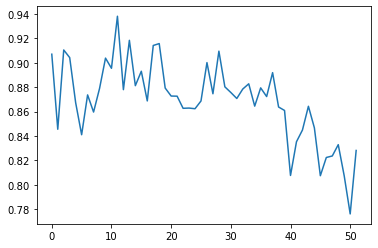

In [190]:
plt.plot(simil_minutes_sep_series.cpu().numpy())

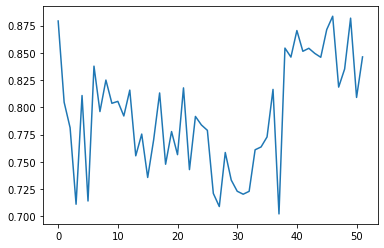

In [191]:
plt.plot(simil_minutes_bb_series.cpu().numpy())

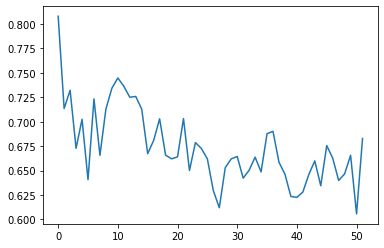

In [192]:
plt.plot(simil_seps_bb_series.cpu().numpy())

In [216]:

df_simil_seps_bb_series = pd.DataFrame([[simil_minutes_sep_series.cpu().numpy().T, simil_minutes_bb_series.cpu().numpy().T, simil_seps_bb_series.cpu().numpy().T]], 
                                       )

In [247]:
# Form array with unique values of dates
dates = minutes.doc_id.unique()

In [248]:
# Convert data to pandas dataframe
# Form a numpy array, will need to transpose
data = np.array([dates, simil_minutes_sep_series.cpu().numpy(),simil_minutes_bb_series.cpu().numpy(),simil_seps_bb_series.cpu().numpy()])
df_simil = pd.DataFrame(data.T, columns = ['doc_id','simil_min_sep', 'simil_min_bb', 'simil_sep_bb'])

In [250]:
df_simil.head()

,doc_id,simil_min_sep,simil_min_bb,simil_sep_bb
0,20071031,0.906957,0.879239,0.807933
1,20080130,0.845563,0.804725,0.713483
2,20080430,0.910424,0.781343,0.732235
3,20080625,0.904183,0.711171,0.672773
4,20081029,0.86725,0.810873,0.702529


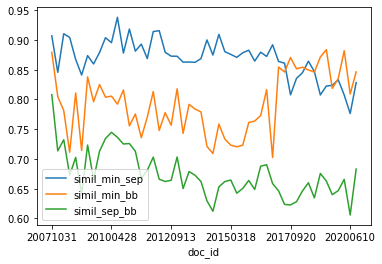

In [251]:
df_simil.plot(x = "doc_id", y = ["simil_min_sep","simil_min_bb", "simil_sep_bb"])
plt.show()

In [252]:
# Write data for R
df_simil.to_pickle('../data/data-gen/df_simil.p')